Fabian Gonzalez Vera | A01367585

__[Github Repository](https://github.com/fabian994/IAAvanzada_M1/tree/62d081c664e43d22936c7b9ff65f81349afeabe8/RetoM1)__

# Módulo 1 Construcción de un modelo estadístico base
##  __[Business case: Understanding profitability in the US financial market](https://rpubs.com/cdorante/tc3006c_p1)__


In [82]:
# industria asignada - Manufacturing industries

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats.mstats import winsorize

In [84]:
dataf = pd.read_csv('dataus2023.csv') #Load dataset data
firmf = pd.read_csv('firmsus2023.csv')
print(dataf.shape, firmf.shape)

(533088, 22) (5615, 7)


Merge industry with data

In [85]:
dataf['qdate'] = pd.PeriodIndex(dataf.q, freq='Q')

In [86]:
firmf.columns

Index(['empresa', 'Nombre', 'status', 'partind', 'naics1', 'naics2',
       'SectorEconomatica'],
      dtype='object')

In [87]:
firms = firmf[['empresa','Nombre','status','naics1']] 
firms.columns=['firm','empresa','status', 'industria']

dataf = pd.merge(dataf, firms, on='firm', how='left') # Merge datasets
dataf.head()

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,adjprice,originalprice,sharesoutstanding,year,fixedassets,yearf,qdate,empresa,status,industria
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.33,104.00,"452,000.00",2000,NaN,NaN,2000Q1,"Agilent Technologies, Inc",activo,Industrias manufactureras
1,A,2000q2,6.00,"4,731,000.00","2,421,000.00","1,925,000.00","73,000.00",0.00,0.00,"161,000.00",...,44.91,73.75,"452,271.97",2000,"1,453,000.00","2,000.00",2000Q2,"Agilent Technologies, Inc",activo,Industrias manufactureras
2,A,2000q3,9.00,"7,401,000.00","3,790,000.00","3,016,000.00","101,000.00",0.00,0.00,"244,000.00",...,29.80,48.94,"453,014.58",2000,"1,581,000.00","2,000.00",2000Q3,"Agilent Technologies, Inc",activo,Industrias manufactureras
3,A,2000q4,12.00,"10,773,000.00","5,522,000.00","4,198,000.00","111,000.00",0.00,0.00,"407,000.00",...,33.34,54.75,"456,366.38",2000,"1,741,000.00","2,000.00",2000Q4,"Agilent Technologies, Inc",activo,Industrias manufactureras
4,A,2001q1,3.00,"2,841,000.00","1,449,000.00","1,113,000.00","19,000.00","-25,000.00",0.00,"119,000.00",...,18.71,30.73,"456,769.74",2001,"1,821,000.00","2,001.00",2001Q1,"Agilent Technologies, Inc",activo,Industrias manufactureras


In [88]:
dataf.columns

Index(['firm', 'q', 'fiscalmonth', 'revenue', 'cogs', 'sgae', 'otherincome',
       'extraordinaryitems', 'finexp', 'incometax', 'totalassets',
       'currentassets', 'inventory', 'totalliabilities', 'currentliabilities',
       'longdebt', 'adjprice', 'originalprice', 'sharesoutstanding', 'year',
       'fixedassets', 'yearf', 'qdate', 'empresa', 'status', 'industria'],
      dtype='object')

***
## 1.1 Calculation of financial variables and ratios

*Calculate log quarterly returns (rq) and log annual returns (ry).*

In [89]:
dataf.set_index(['firm','qdate'],inplace=True)
dataf['ry'] = np.log(dataf['adjprice']) - np.log(dataf.groupby(['firm'])['adjprice'].shift(4))

In [90]:

dataf['rq'] = np.log(dataf['adjprice']) - np.log(dataf.groupby(['firm'])['adjprice'].shift(1))

In [91]:
# Calculate future quarterly return

dataf['f1rq'] = dataf.groupby(['firm'])['rq'].shift(-1)
dataf['f4rq'] = dataf.groupby(['firm'])['rq'].shift(-4)

dataf['f1ry'] = dataf.groupby(['firm'])['ry'].shift(-1)
dataf['f4ry'] = dataf.groupby(['firm'])['ry'].shift(-4)

In [92]:
dataf[['rq','f1rq','ry','f4rq','f1ry','f4ry']].head(10)

rq  f1rq    ry  f4rq  f1ry  f4ry
firm qdate                                     
A    2000Q1   NaN -0.34   NaN -0.58   NaN -1.22
     2000Q2 -0.34 -0.41   NaN  0.06   NaN -0.82
     2000Q3 -0.41  0.11   NaN -0.51   NaN -0.92
     2000Q4  0.11 -0.58   NaN  0.38 -1.22 -0.65
     2001Q1 -0.58  0.06 -1.22  0.20 -0.82  0.13
     2001Q2  0.06 -0.51 -0.82 -0.39 -0.92 -0.32
     2001Q3 -0.51  0.38 -0.92 -0.59 -0.65 -0.40
     2001Q4  0.38  0.20 -0.65  0.32  0.13 -0.46
     2002Q1  0.20 -0.39  0.13 -0.31 -0.32 -0.98
     2002Q2 -0.39 -0.59 -0.32  0.40 -0.40 -0.19


* *Calculate operating profit (also called earnings before interest and taxes) : ebit = revenue - cogs - sgae*
* *Calculate operating profit margin: opm = ebit / revenue*
* *Calculate net income as: netincome = ebit + otherincome + extraordinaryitems - financial expenses - incometax*
* *Calculate profit margin (ratio) as: pm = ni / revenue*
* *Calculate asset turn over ratio: ato = revenue / totalassets*
* *Calculate acid ratio: acidratio = currentassets / currentliabilities*
* *Calculate financial leverage ratio as: finlev=longdebt / totalassets*
* *Calculate market value as: mvalue = originalprice * sharesoutstanding*
* *Calculate book value as: bookvalue = totalassets - totalliabilities*

In [93]:
dataf['ebit'] = dataf['revenue'] - dataf['cogs'] - dataf['sgae']
dataf['opm'] = np.where(dataf['revenue']==0, np.NaN, dataf['ebit']/dataf['revenue'])
dataf['netincome'] = dataf['ebit'] + dataf['otherincome'] + dataf['extraordinaryitems'] - dataf['finexp'] - dataf['incometax']
dataf['pm'] = np.where(dataf['revenue']==0, np.NaN, dataf['netincome']/dataf['revenue'])
dataf['ato'] = np.where(dataf['totalassets']==0, np.NaN, dataf['revenue']/dataf['totalassets'])
dataf['acidratio'] = np.where(dataf['currentliabilities']==0, np.NaN, dataf['currentassets']/dataf['currentliabilities'])
dataf['finlev'] = np.where(dataf['totalassets']==0, np.NaN, dataf['longdebt']/dataf['totalassets'])
dataf['mvalue'] = dataf['originalprice'] * dataf['sharesoutstanding']
dataf['bookvalue'] = dataf['totalassets'] - dataf['totalliabilities']

Dummy encoding
codifica variables categorias como numericas, genera n-1 variables, escoge una variable como base, el base es 0 en todas las demas variables.

Cuando las variables en regresion lineal son dummies, no se interpretan de la manera que se interpretan las demas variables, lo que sucede es que hay n ecuaciones de regresion como hay n dummies, una ecuacion para cada categoria.

Su Beta es la distancia que la linea con ciertas variables categoricas esta de la otra linea sin varibable.



In [94]:
dataf.head()

q  fiscalmonth       revenue         cogs         sgae  \
firm qdate                                                                 
A    2000Q1  2000q1          NaN           NaN          NaN          NaN   
     2000Q2  2000q2         6.00  4,731,000.00 2,421,000.00 1,925,000.00   
     2000Q3  2000q3         9.00  7,401,000.00 3,790,000.00 3,016,000.00   
     2000Q4  2000q4        12.00 10,773,000.00 5,522,000.00 4,198,000.00   
     2001Q1  2001q1         3.00  2,841,000.00 1,449,000.00 1,113,000.00   

             otherincome  extraordinaryitems  finexp  incometax  totalassets  \
firm qdate                                                                     
A    2000Q1          NaN                 NaN     NaN        NaN          NaN   
     2000Q2    73,000.00                0.00    0.00 161,000.00 7,321,000.00   
     2000Q3   101,000.00                0.00    0.00 244,000.00 7,827,000.00   
     2000Q4   111,000.00                0.00    0.00 407,000.00 8,425,000.00   
     2001Q1    19,000.00          -25,000.00    0.00 119,000.00 9,208,000.00   

             ...  f4ry         ebit  opm  netincome   pm  ato  acidratio  \
firm qdate   ...                                                           
A    2000Q1  ... -1.22          NaN  NaN        NaN  NaN  NaN        NaN   
     2000Q2  ... -0.82   385,000.00 0.08 297,000.00 0.06 0.65       2.31   
     2000Q3  ... -0.92   595,000.00 0.08 452,000.00 0.06 0.95       2.13   
     2000Q4  ... -0.65 1,053,000.00 0.10 757,000.00 0.07 1.28       2.05   
     2001Q1  ...  0.13   279,000.00 0.10 154,000.00 0.05 0.31       1.78   

             finlev        mvalue    bookvalue  
firm qdate                                      
A    2000Q1     NaN 47,008,000.00          NaN  
     2000Q2    0.00 33,355,057.57 4,642,000.00  
     2000Q3    0.00 22,169,400.96 4,902,000.00  
     2000Q4    0.00 24,986,059.36 5,265,000.00  
     2001Q1    0.00 14,036,533.81 5,541,000.00  

[5 rows x 39 columns]

***
## 1.2 Firm Composition of the US financial market

*Show how many active firms by industry there are in the sample*

In [95]:
pd.options.display.float_format = '{:,.2f}'.format

print(dataf.status.unique())
# Count how many active firms exits by industry
active_2023q2 = dataf.loc[(dataf['status']=='activo') & (dataf['q']=='2023q2')]
#print(active_2023q2)

active_2023q2[['industria','empresa']].groupby('industria').count()


['activo' 'cancelado']


,empresa
industria,
-,2
"Agricultura, ganadería, aprovechamiento forestal, pesca y caza",17
Comercio al por mayor,79
Comercio al por menor,145
Construcción,46
"Empresas de electricidad, gas y agua",77
Industrias manufactureras,1540
Información en medios masivos,256
"Minería, explotación de canteras y extracción de petróleo y gas",113


*For each industry (and for all industries), what can you say about the typical firm size in terms of market value and book value? How much these variables change within each industry? How firm size (in market value) is distributed? You have to do the right descriptive statistics*

**R**: As shown in the dataframe and the plots, the typical firm in most industries is small in size, with the extreme values of max, std and 75% quantile coming from a few firms with massive numbers, as for how much these variables changes within the industries, most values are in the lower end of the scale with a few on the higher end, this can be appreciated with the jump of the values of 25% quantile (<lambda_0>), median and 75% quantile (<lambda_1>).

In [96]:
q1 = 0.25
q2 = 0.75
q25 = lambda x: x.quantile(q1)
q75 = lambda x: x.quantile(q2)
industrysummary = active_2023q2.groupby('industria').agg(
    {
        'empresa': ['count'],
        'mvalue': ['min','max','median','std',q25,q75],
        'bookvalue': ['min','max','median','std',q25,q75],
    }
)


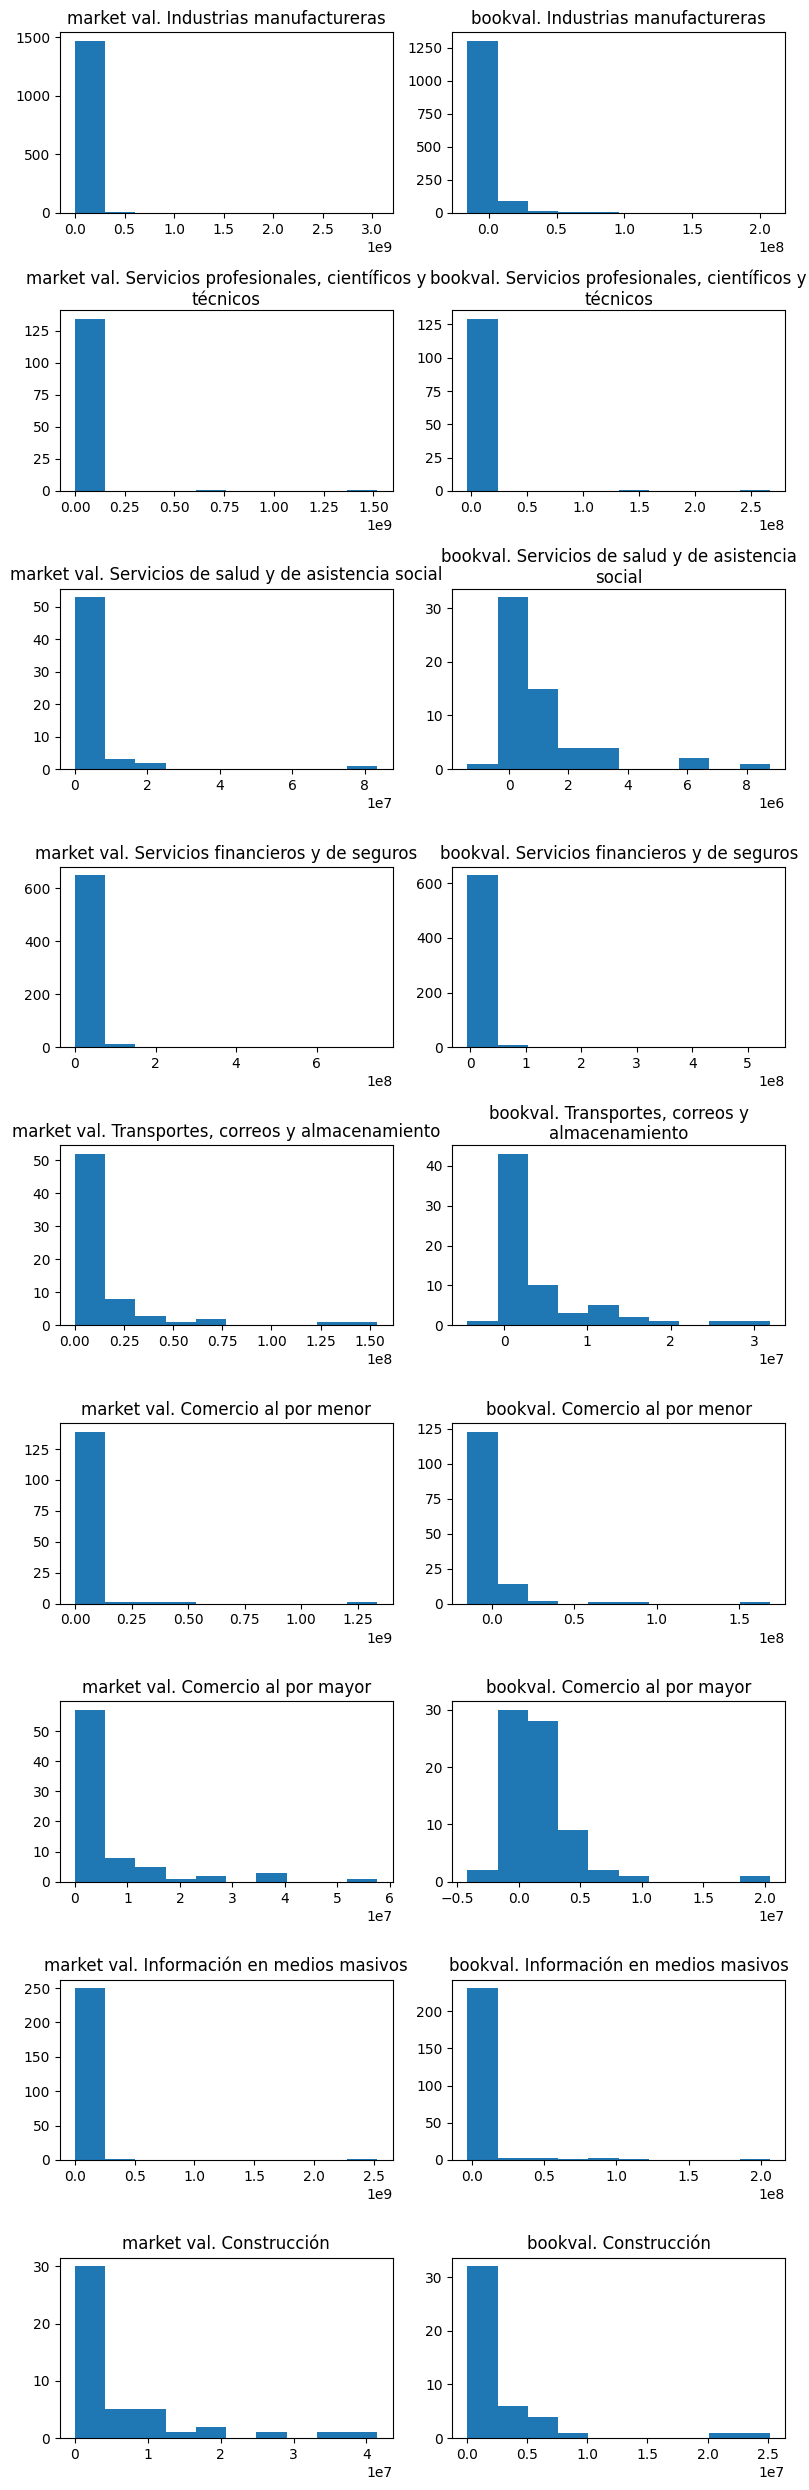

In [97]:
indL = ['Industrias manufactureras',
       'Servicios profesionales, científicos y técnicos',
       'Servicios de salud y de asistencia social',
       'Servicios financieros y de seguros',
       'Transportes, correos y almacenamiento', 'Comercio al por menor',
       'Comercio al por mayor', 'Información en medios masivos',
       'Construcción',
       'Servicios de apoyo a los negocios y manejo de residuos y desechos, y servicios de remediación',
       'Minería, explotación de canteras y extracción de petróleo y gas',
       'Empresas de electricidad, gas y agua',
       'Servicios inmobiliarios y de alquiler de bienes muebles e intangibles',
       'Agricultura, ganadería, aprovechamiento forestal, pesca y caza','Servicios educativos',
       'Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos',
       'Servicios de alojamiento temporal y de preparación de alimentos y bebidas',
       'Otros servicios excepto actividades gubernamentales']

# indDF = active_2023q2.loc[(active_2023q2['industria']=='Agricultura, ganadería, aprovechamiento forestal, pesca y caza')]
# mval = indDF['mvalue']
# hist=mval.plot.hist(bins=17,alpha=0.5,title="Agricultura hist")

f, axes = plt.subplots(9,2, constrained_layout=True, figsize=(8,25))
lc = 0
for c, i in enumerate(axes):
  indDF = active_2023q2.loc[(active_2023q2['industria']== indL[lc])]
  mval = indDF['mvalue']
  bval = indDF['bookvalue']
  
  axes[c][0].hist(mval)
  axes[c][1].hist(bval)
  axes[c][0].set_title('market val. ' + indL[lc], loc='center', wrap=True)
  axes[c][1].set_title('bookval. ' + indL[lc], loc='center', wrap=True)
  lc+=1
plt.tight_layout()
    

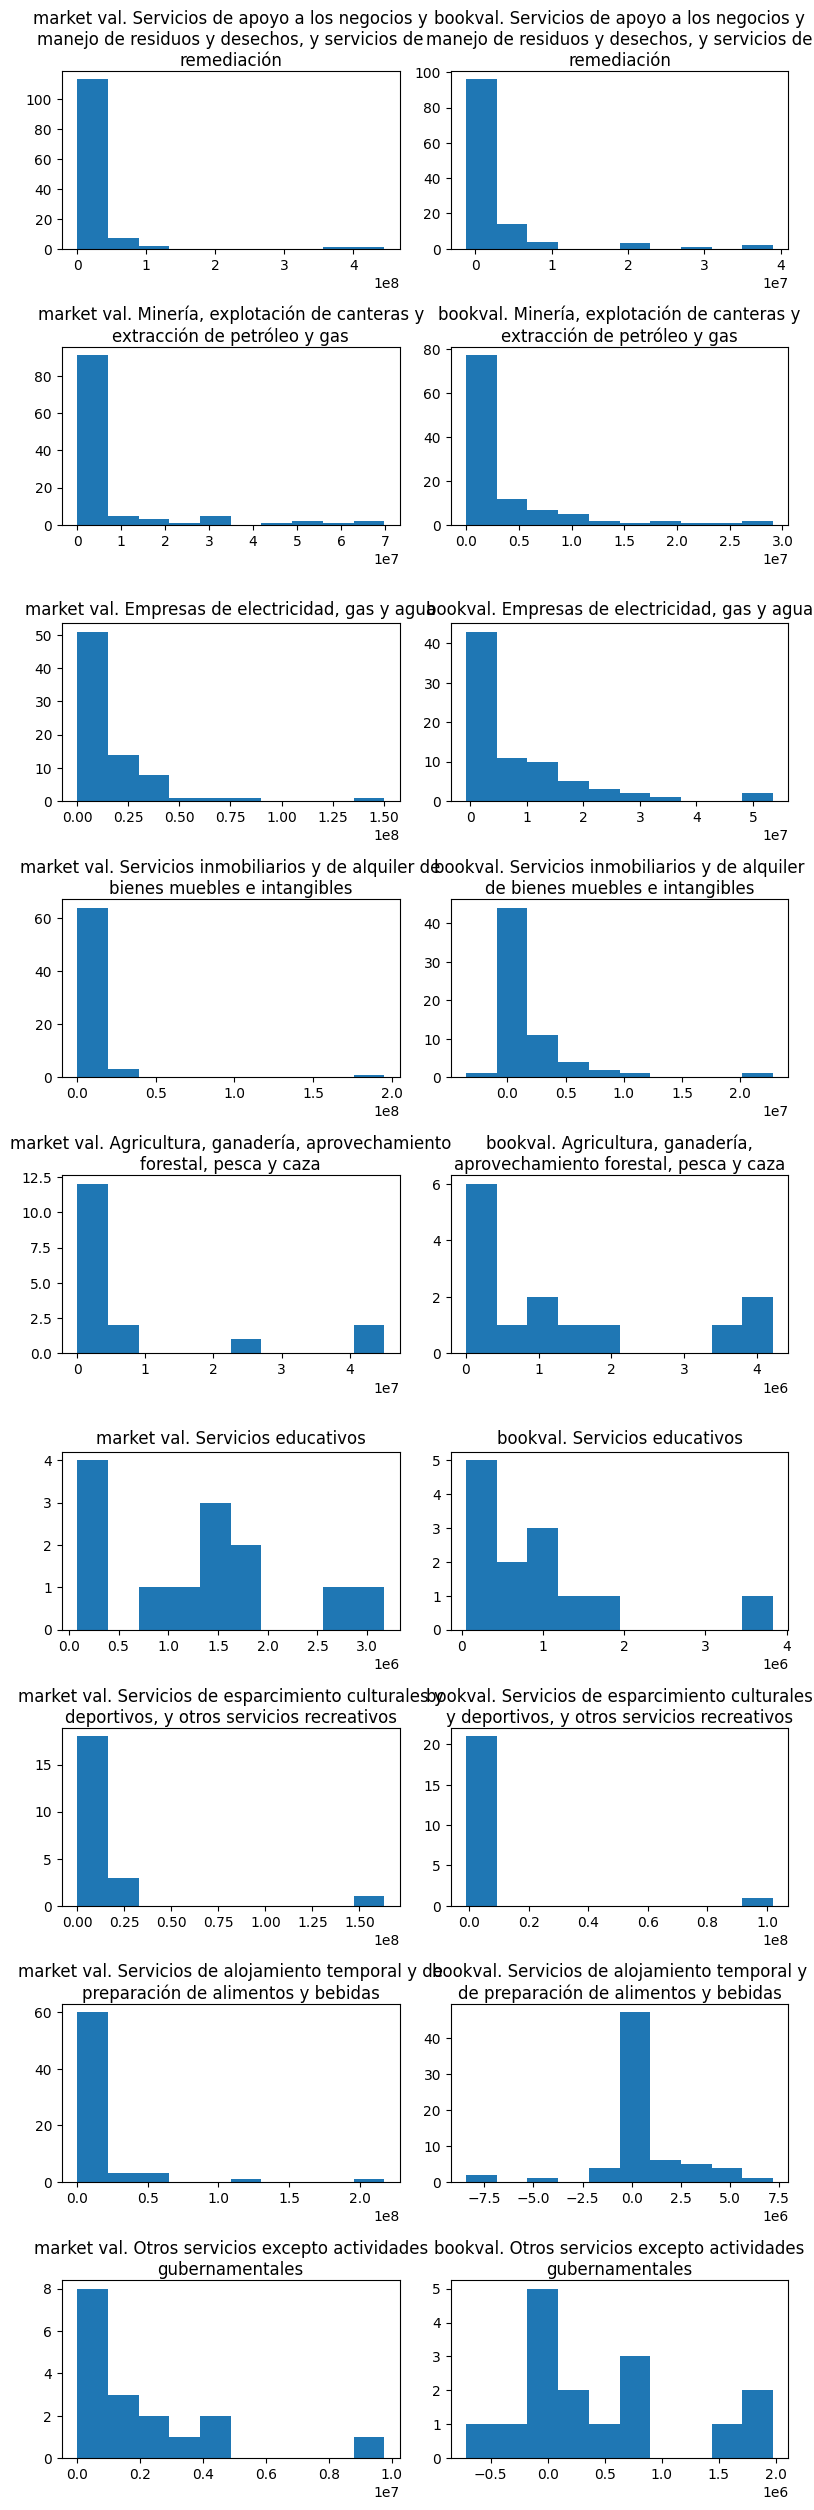

In [98]:
f, axes = plt.subplots(9,2, constrained_layout=True, figsize=(8,25))
lc = 9
for c, i in enumerate(axes):
  indDF = active_2023q2.loc[(active_2023q2['industria']== indL[lc])]
  mval = indDF['mvalue']
  bval = indDF['bookvalue']
  
  axes[c][0].hist(mval)
  axes[c][1].hist(bval)
  axes[c][0].set_title('market val. ' + indL[lc], loc='center', wrap=True)
  axes[c][1].set_title('bookval. ' + indL[lc], loc='center', wrap=True)
  lc+=1
plt.tight_layout()

*Which are the biggest 10 US firms in terms of market value and how far they are from the typical size of a US firm?*

**R:** The difference is massive, one example is with Microsoft, whose mvalue is the max of the its industry, while the 25% quantile(2,370,194.81), median(518,408.36) and 75% values(8,323,585.70) are way lower than MSFT mvalue of 2,532,080,938.79

In [99]:
active_2023q2[['mvalue','empresa','industria']].sort_values(by='mvalue',ascending=False).head(10)

,,mvalue,empresa,industria
firm,qdate,,,
AAPL,2023Q2,"3,050,896,326.94",Apple Inc,Industrias manufactureras
MSFT,2023Q2,"2,532,080,938.79",Microsoft Corp,Información en medios masivos
GOOGL,2023Q2,"1,519,830,900.00",Alphabet Inc,"Servicios profesionales, científicos y técnicos"
AMZN,2023Q2,"1,337,539,706.77","Amazon.Com, Inc",Comercio al por menor
NVDA,2023Q2,"1,044,859,400.00",Nvidia Corp,Industrias manufactureras
TSLA,2023Q2,"829,681,140.87","Tesla, Inc",Industrias manufactureras
BRK_A,2023Q2,"750,735,436.68",Berkshire Hathaway Inc,Servicios financieros y de seguros
META,2023Q2,"735,452,839.12","Meta Platforms, Inc","Servicios profesionales, científicos y técnicos"
UNH,2023Q2,"447,491,234.90",Unitedhealth Group Inc,Servicios financieros y de seguros


*Which are the biggest 10 US firms in terms of book value and how far they are from the typical size of a US firm?*

**R:** There is a massive difference between the typical firm and the biggest ones.

In [100]:
active_2023q2[['bookvalue','empresa','industria']].sort_values(by='bookvalue',ascending=False).head(10)

,,bookvalue,empresa,industria
firm,qdate,,,
BRK_A,2023Q2,"539,883,000.00",Berkshire Hathaway Inc,Servicios financieros y de seguros
JPM,2023Q2,"312,516,000.00",Jpmorgan Chase & Co,Servicios financieros y de seguros
BAC,2023Q2,"283,319,000.00",Bank Of America Corp,Servicios financieros y de seguros
GOOGL,2023Q2,"267,141,000.00",Alphabet Inc,"Servicios profesionales, científicos y técnicos"
C,2023Q2,"209,422,000.00",Citigroup Inc,Servicios financieros y de seguros
XOM,2023Q2,"206,997,000.00",Exxon Mobil Corp,Industrias manufactureras
MSFT,2023Q2,"206,223,000.00",Microsoft Corp,Información en medios masivos
WFC,2023Q2,"181,952,000.00",Wells Fargo & Company,Servicios financieros y de seguros
AMZN,2023Q2,"168,602,000.00","Amazon.Com, Inc",Comercio al por menor


***
## 1.3 Evolution of the US financial market

*Considering the whole history of financial data for all firms, and only annual fiscal information (selecting fiscalmonth=12) :*

*How the total market value of the US market has changed over the years? Do a table and/or graph and explain*

**R:** The total market val. has enjoyed a continuous growth with some bumps, this can be appreciated with around the time of the burst of the dot-com bubble in the early 2000´s, the global financial crisis around 2008. And the sudden increase around the year 2020 can be explained with the COVID-19 pandemic that while it slowed the economy, companies experienced an unprecedented growth due to people having more disposable income due to not having to buy certain things.

In [101]:
dataYearly = dataf[(dataf['fiscalmonth']==12)]
fmarket = dataYearly[['year', 'mvalue', 'revenue', 'netincome']].groupby('year').sum()
fmarket

,mvalue,revenue,netincome
year,,,
2000,"12,814,978,634.15","6,650,301,475.86","344,723,426.83"
2001,"11,494,392,671.37","7,757,319,661.87","67,530,325.20"
2002,"9,494,723,157.61","7,575,463,606.79","-57,773,458.77"
2003,"11,675,951,523.21","8,213,607,184.22","364,552,095.88"
2004,"13,230,878,635.88","9,111,916,600.06","431,717,996.76"
2005,"13,789,108,526.52","9,975,745,857.16","522,880,104.83"
2006,"15,461,254,772.55","10,941,769,398.44","657,926,147.83"
2007,"16,149,130,338.06","11,603,740,650.63","610,497,891.61"
2008,"10,395,016,561.41","11,769,845,526.77","342,187,423.38"


<Axes: xlabel='year'>

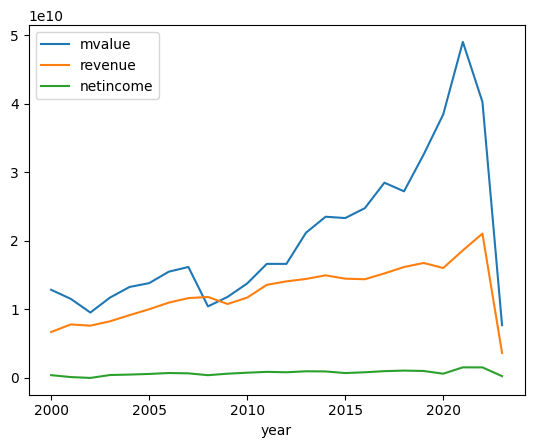

In [102]:
fmarket.plot()

*How total revenue and total net income of all US firms has changed over the years? Do a table and/or graph and explain*

**R:** The Total Revenue of all firms has changed dramatically over time, and the difference between firms varies a lot, some like Walmart have enjoyed a steady growth, while others have quite a few of ups and downs such as Exxon Mobil who saw a steady growth until 2008 when it plummeted and then recovered until 2011 when it entered into a decline that didn´t recover until around 2020.

The Total Net Income of all US firms has also changed dramatically overtime, and what has been discussed about the Total Revenue also applies to the Net Income.

These extreme changes don´t just happen alone, they coincide with the changes around the world.

In [103]:
dataYearly = dataf[(dataf['fiscalmonth']==12)]
usfirms = dataYearly[['year', 'empresa','mvalue', 'revenue', 'netincome']].groupby(['year','empresa']).sum()
usfirms

mvalue       revenue    netincome
year empresa                                                             
2000 1 800 Flowers Com Inc          328,875.93    385,250.00   -66,830.00
     3M Company                  47,529,232.53 16,724,000.00 1,782,000.00
     3com Corp                   20,216,727.88  4,333,942.00   674,303.00
     3d Systems Corp                      0.00    109,675.00     8,144.00
     7 Eleven Inc                   916,690.22  9,451,047.00   108,292.00
...                                        ...           ...          ...
2023 Worthington Industries, Inc  3,456,505.21  4,916,392.00   256,528.00
     Yext, Inc                    1,173,426.35    400,850.00   -65,938.00
     Zoom Video Comm, Inc        21,696,878.74  4,392,960.00   103,711.00
     Zumiez Inc                     359,387.91    958,380.00    21,034.00
     Zuora, Inc                   1,338,740.00    396,087.00  -197,970.00

[58994 rows x 3 columns]

***
## 1.4 Learing about one industry

In [104]:
# industria asignada - Manufacturing industries
manufacturyInds = dataf.loc[(dataf['industria']=='Industrias manufactureras')]
manufacturyInds

q  fiscalmonth       revenue         cogs         sgae  \
firm qdate                                                                 
A    2000Q1  2000q1          NaN           NaN          NaN          NaN   
     2000Q2  2000q2         6.00  4,731,000.00 2,421,000.00 1,925,000.00   
     2000Q3  2000q3         9.00  7,401,000.00 3,790,000.00 3,016,000.00   
     2000Q4  2000q4        12.00 10,773,000.00 5,522,000.00 4,198,000.00   
     2001Q1  2001q1         3.00  2,841,000.00 1,449,000.00 1,113,000.00   
...             ...          ...           ...          ...          ...   
ZYNE 2022Q3  2022q3         9.00          0.00         0.00    26,565.56   
     2022Q4  2022q4        12.00          0.00         0.00    35,251.54   
     2023Q1  2023q1         3.00          0.00         0.00    10,471.17   
     2023Q2  2023q2         6.00          0.00         0.00    21,607.38   
     2023Q3  2023q3          NaN           NaN          NaN          NaN   

             otherincome  extraordinaryitems  finexp  incometax  totalassets  \
firm qdate                                                                     
A    2000Q1          NaN                 NaN     NaN        NaN          NaN   
     2000Q2    73,000.00                0.00    0.00 161,000.00 7,321,000.00   
     2000Q3   101,000.00                0.00    0.00 244,000.00 7,827,000.00   
     2000Q4   111,000.00                0.00    0.00 407,000.00 8,425,000.00   
     2001Q1    19,000.00          -25,000.00    0.00 119,000.00 9,208,000.00   
...                  ...                 ...     ...        ...          ...   
ZYNE 2022Q3      -893.80                0.00 -439.59       0.00    62,366.74   
     2022Q4      -631.13                0.00 -846.86       0.00    55,520.89   
     2023Q1       -89.98               -0.00 -447.31       0.00    48,636.53   
     2023Q2      -164.56                0.00 -882.03       0.00    40,476.56   
     2023Q3          NaN                 NaN     NaN        NaN          NaN   

             ...  f4ry         ebit  opm  netincome   pm  ato  acidratio  \
firm qdate   ...                                                           
A    2000Q1  ... -1.22          NaN  NaN        NaN  NaN  NaN        NaN   
     2000Q2  ... -0.82   385,000.00 0.08 297,000.00 0.06 0.65       2.31   
     2000Q3  ... -0.92   595,000.00 0.08 452,000.00 0.06 0.95       2.13   
     2000Q4  ... -0.65 1,053,000.00 0.10 757,000.00 0.07 1.28       2.05   
     2001Q1  ...  0.13   279,000.00 0.10 154,000.00 0.05 0.31       1.78   
...          ...   ...          ...  ...        ...  ...  ...        ...   
ZYNE 2022Q3  ...  0.59   -26,565.56  NaN -27,019.77  NaN 0.00       6.45   
     2022Q4  ...   NaN   -35,251.54  NaN -35,035.81  NaN 0.00       5.97   
     2023Q1  ...   NaN   -10,471.17  NaN -10,113.84  NaN 0.00       4.95   
     2023Q2  ...   NaN   -21,607.38  NaN -20,889.91  NaN 0.00       3.43   
     2023Q3  ...   NaN          NaN  NaN        NaN  NaN  NaN        NaN   

             finlev        mvalue    bookvalue  
firm qdate                                      
A    2000Q1     NaN 47,008,000.00          NaN  
     2000Q2    0.00 33,355,057.57 4,642,000.00  
     2000Q3    0.00 22,169,400.96 4,902,000.00  
     2000Q4    0.00 24,986,059.36 5,265,000.00  
     2001Q1    0.00 14,036,533.81 5,541,000.00  
...             ...           ...          ...  
ZYNE 2022Q3    0.00     33,491.25    52,756.75  
     2022Q4    0.00     24,943.24    46,228.76  
     2023Q1    0.00     22,941.57    38,966.55  
     2023Q2    0.00     17,490.71    29,020.57  
     2023Q3     NaN     71,200.05          NaN  

[216105 rows x 39 columns]

In [105]:
manufacturyInds[['industria','empresa']].groupby('industria').count()

,empresa
industria,
Industrias manufactureras,216105


### 1.4.1 Descriptive statistics for your industry

*Using the subsample of your industry and using annual fiscal information (selecting rows with fiscalmonth=12), and the most recent complete year (2022), do the following:*

In [106]:
MIy = manufacturyInds.loc[(manufacturyInds['status']=='activo') & (manufacturyInds['fiscalmonth']==12)]
MIy.head()

q  fiscalmonth       revenue         cogs         sgae  \
firm qdate                                                                 
A    2000Q4  2000q4        12.00 10,773,000.00 5,522,000.00 4,198,000.00   
     2001Q4  2001q4        12.00  8,396,000.00 5,166,000.00 4,008,000.00   
     2002Q4  2002q4        12.00  6,010,000.00 3,694,000.00 3,923,000.00   
     2003Q4  2003q4        12.00  6,056,000.00 3,762,000.00 3,019,000.00   
     2004Q4  2004q4        12.00  7,181,000.00 4,058,000.00 2,737,000.00   

             otherincome  extraordinaryitems  finexp    incometax  \
firm qdate                                                          
A    2000Q4   111,000.00                0.00    0.00   407,000.00   
     2001Q4   301,000.00          580,000.00    0.00   -71,000.00   
     2002Q4    60,000.00          -10,000.00    0.00  -525,000.00   
     2003Q4    35,000.00         -268,000.00    0.00 1,100,000.00   
     2004Q4    54,000.00                0.00    0.00    91,000.00   

             totalassets  ...  f4ry          ebit   opm     netincome    pm  \
firm qdate                ...                                                 
A    2000Q4 8,425,000.00  ... -0.65  1,053,000.00  0.10    757,000.00  0.07   
     2001Q4 7,986,000.00  ... -0.46   -778,000.00 -0.09    174,000.00  0.02   
     2002Q4 8,203,000.00  ...  0.49 -1,607,000.00 -0.27 -1,032,000.00 -0.17   
     2003Q4 6,297,000.00  ... -0.19   -725,000.00 -0.12 -2,058,000.00 -0.34   
     2004Q4 7,056,000.00  ...  0.32    386,000.00  0.05    349,000.00  0.05   

             ato  acidratio  finlev        mvalue    bookvalue  
firm qdate                                                      
A    2000Q4 1.28       2.05    0.00 24,986,059.36 5,265,000.00  
     2001Q4 1.05       2.40    0.00 13,219,949.12 5,659,000.00  
     2002Q4 0.73       2.24    0.14  8,387,758.60 4,627,000.00  
     2003Q4 0.96       2.04    0.18 13,922,599.19 2,824,000.00  
     2004Q4 1.02       2.45    0.16 11,732,870.20 3,569,000.00  

[5 rows x 39 columns]

In [107]:
MIy2022= manufacturyInds.loc[(manufacturyInds['year']==2022)]
MIy2022.head()

q  fiscalmonth      revenue         cogs         sgae  \
firm qdate                                                                
A    2022Q1  2022q1         3.00 1,674,000.00   764,000.00   534,000.00   
     2022Q2  2022q2         6.00 3,281,000.00 1,510,000.00 1,035,000.00   
     2022Q3  2022q3         9.00 4,999,000.00 2,289,000.00 1,563,000.00   
     2022Q4  2022q4        12.00 6,848,000.00 3,126,000.00 2,104,000.00   
AA   2022Q1  2022q1         3.00 3,293,000.00 2,181,000.00   338,000.00   

             otherincome  extraordinaryitems    finexp  incometax  \
firm qdate                                                          
A    2022Q1   -37,000.00                0.00 20,000.00  36,000.00   
     2022Q2   -44,000.00                0.00 40,000.00  95,000.00   
     2022Q3   -41,000.00                0.00 57,000.00 163,000.00   
     2022Q4   -39,000.00                0.00 75,000.00 250,000.00   
AA   2022Q1    14,000.00          -84,000.00 25,000.00 210,000.00   

              totalassets  ...  f4ry         ebit  opm    netincome   pm  ato  \
firm qdate                 ...                                                  
A    2022Q1 10,327,000.00  ...  0.05   376,000.00 0.22   283,000.00 0.17 0.16   
     2022Q2 10,455,000.00  ...  0.02   736,000.00 0.22   557,000.00 0.17 0.31   
     2022Q3 10,484,000.00  ... -0.01 1,147,000.00 0.23   886,000.00 0.18 0.48   
     2022Q4 10,532,000.00  ...   NaN 1,618,000.00 0.24 1,254,000.00 0.18 0.65   
AA   2022Q1 15,988,000.00  ... -0.74   774,000.00 0.24   469,000.00 0.14 0.21   

             acidratio  finlev        mvalue    bookvalue  
firm qdate                                                 
A    2022Q1       2.19    0.26 39,714,003.18 5,154,000.00  
     2022Q2       2.01    0.26 35,477,555.81 5,122,000.00  
     2022Q3       1.94    0.26 35,983,731.28 5,091,000.00  
     2022Q4       2.03    0.26 44,307,180.79 5,305,000.00  
AA   2022Q1       1.62    0.11 16,691,834.97 6,257,000.00  

[5 rows x 39 columns]

*Show descriptive statistics for quarterly return, annual return, total assets, revenue, netincome and all financial ratios calculated above. Provide a clear interpretation of the descriptive statistics of revenue and 1 financial ratio*

**R:** The descriptive statistics of revenue show that some extreme values beyond the 75% are influencing the statistics. 

For the OPM shows that the operating margin is very spread, also one can conclude that the OPM for the manufacturing industry are quite tight.

In [108]:
MI22dataset = MIy2022[['rq','f1rq','ry','f4rq','totalassets','revenue','netincome','opm','pm','ato','acidratio','finlev','mvalue','bookvalue']]
MI22dataset.describe()

#hay que describir revenue y un financial ratio

,rq,f1rq,ry,f4rq,totalassets,revenue,netincome,opm,pm,ato,acidratio,finlev,mvalue,bookvalue
count,"6,295.00","6,258.00","6,003.00","4,580.00","6,285.00","6,285.00","6,273.00","5,272.00","5,272.00","6,285.00","6,273.00","6,285.00","6,208.00","6,285.00"
mean,-0.15,-0.11,-0.57,-0.04,"6,101,368.39","2,839,863.48","303,661.28",-25.19,-25.40,0.38,5.57,0.22,"10,747,972.93","2,310,365.56"
std,0.38,0.40,0.78,0.36,"23,719,959.03","14,375,945.93","2,484,878.29",294.62,306.03,0.48,8.25,0.60,"71,491,234.31","9,598,008.48"
min,-4.23,-4.23,-4.86,-3.03,80.37,-582.50,"-6,752,000.00","-10,287.58","-10,483.11",-0.01,0.00,0.00,881.01,"-17,635,000.00"
25%,-0.31,-0.26,-0.98,-0.16,"112,372.00","3,117.55","-33,279.00",-0.77,-0.80,0.03,1.75,0.02,"96,819.39","41,649.30"
50%,-0.11,-0.06,-0.36,-0.01,"453,579.00","111,671.00","-4,116.00",0.02,0.00,0.25,2.87,0.15,"634,935.08","226,000.00"
75%,0.06,0.11,-0.05,0.11,"2,416,657.00","1,084,699.00","61,961.00",0.13,0.09,0.56,6.17,0.31,"3,298,902.70","916,600.00"
max,2.66,2.66,1.95,2.17,"370,152,000.00","413,680,000.00","99,803,000.00","1,290.29","1,245.78",13.56,201.08,28.66,"2,849,537,593.01","202,473,000.00"


*Using annual fiscal data (selecting rows with fiscalmonth=12), and all years:*


*Show a correlation matrix with the same variables you used for descriptive statistics above, but in the case of totalassets, revenue and netincome, use the logarithmic transformation of the values. Which variables have strongest and significant linear relationship with stock returns (annual and quarterly)? Explain*

**R:** The ones with the strongest correlation are REVENUE, MVALUE, TOTALASSETS, OPM, PM, ATO. 

In [109]:
MIyds = MIy[['rq','f1rq','ry','f4rq','totalassets','revenue','netincome','opm','pm','ato','acidratio','finlev','mvalue','bookvalue']]
finVars = ['totalassets','revenue','netincome','mvalue','bookvalue']
for i in finVars:
    MIyds[i] = np.where(MIyds[i]==0, np.NaN, np.log(MIyds[i])) # Logaritmix transformations of totalassets, revenue and netincome

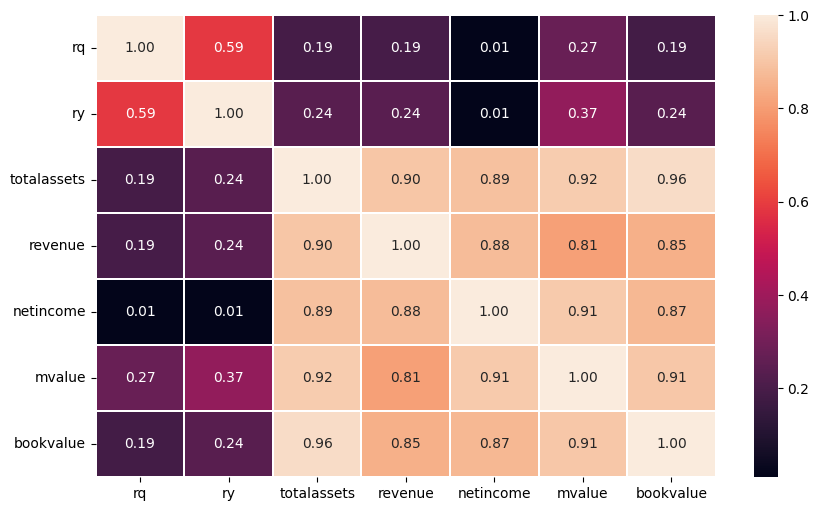

In [110]:
corrMatNums = MIyds[['rq','ry','totalassets','revenue','netincome','mvalue','bookvalue']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corrMatNums, annot=True, fmt='0.2f',linewidth=0.2)
plt.show()

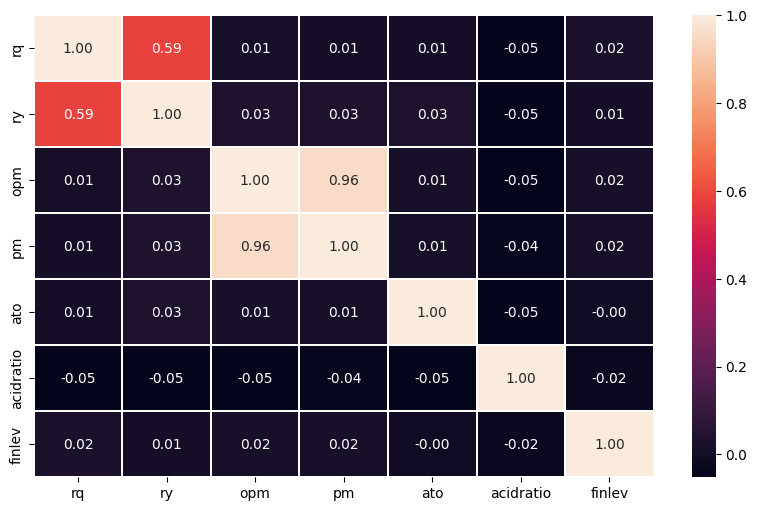

In [111]:
corrMatRatios = MIyds[['rq','ry','opm','pm','ato','acidratio','finlev']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corrMatRatios, annot=True, fmt='0.2f',linewidth=0.2)
plt.show()

*Select 2-3 variables and 2-3 ratios with the strongest correlation with future log quarterly returns and do the following:<br>*
* Selected Variables:  REVENUE, TOTALASSETS, MVALUE
* Selected Ratios: OPM, PM, ATO

*Do histograms for each factor/variables and interpret them*

**R:** The values are skewed to the right as most firms have values on the lower end. And for ratios most firms in the manufacturing industry had tight margins.

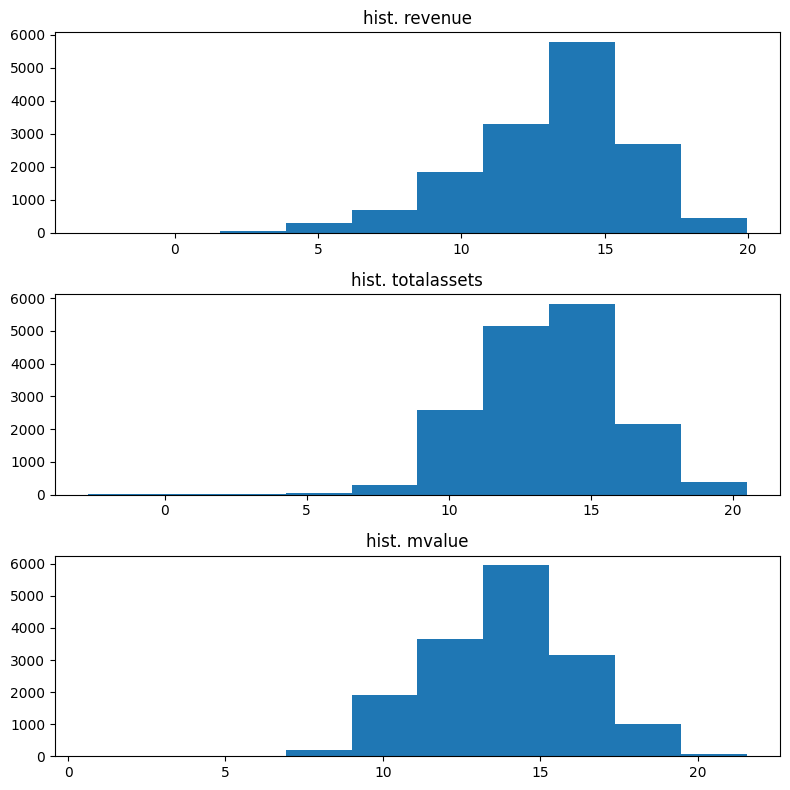

In [112]:
sv = ['revenue','totalassets','mvalue']#'totalassets','revenue','netincome','mvalue'
sr = ['opm','pm','ato']
f, axes = plt.subplots(3,1, constrained_layout=True, figsize=(8,8))
lc = 0
for c, i in enumerate(axes):
    vals = pd.DataFrame(MIyds[[sv[lc]]])
    axes[c].hist(vals)
    axes[c].set_title('hist. ' + sv[lc], loc='center', wrap=True)
    lc+=1
plt.tight_layout()

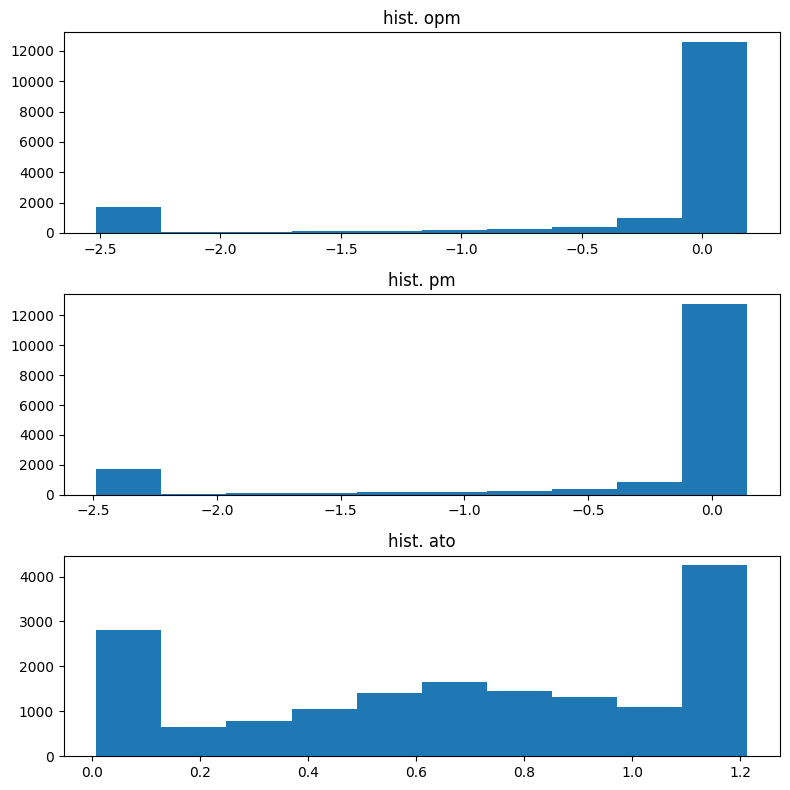

In [113]:
f, axes = plt.subplots(3,1, constrained_layout=True, figsize=(8,8))
lc = 0
for c, i in enumerate(axes):
    vals = MIyds[[sr[lc]]].copy()
    
    vals=vals.reset_index() #Winsorization of ratios
    vals = vals.drop(['firm', 'qdate'], axis=1)
    vals = winsorize(vals[sr[lc]], limits=[0.1, 0.2])

    axes[c].hist(vals)
    axes[c].set_title('hist. ' + sr[lc], loc='center', wrap=True)
    lc+=1
plt.tight_layout()

*Do plots to visualize the possible relationship each factor might have with quarterly returns (the dependent variable).*

In [114]:
from IPython.display import Markdown
import warnings
warnings.filterwarnings('ignore') # Ignore pairplot warings

The general shape of the slope is not very clear because of it tends to be horizontal

['ato', 'mvalue', 'opm', 'pm', 'revenue', 'rq', 'totalassets', 'winsorized_ato', 'winsorized_opm', 'winsorized_pm']


## rq

### rq vs ['ato', 'mvalue', 'opm', 'pm', 'revenue', 'rq', 'totalassets', 'winsorized_ato', 'winsorized_opm', 'winsorized_pm']

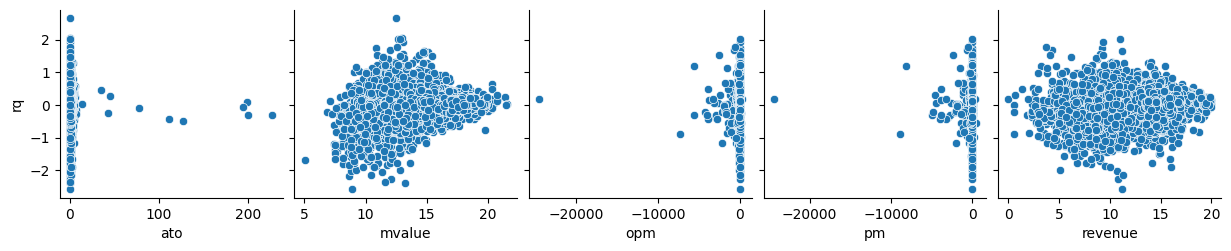

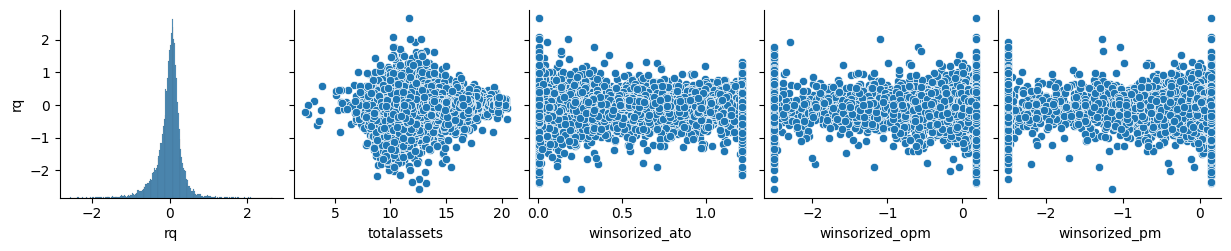

In [115]:
df2 = MIyds.copy()

df2=df2.reset_index()
df2 = df2.drop(['firm', 'qdate',	'ry',	'f4rq'], axis=1)
#df2
df2 = df2[['rq','revenue','totalassets','mvalue','opm','pm','ato']]

ratiosl = ['opm','pm','ato']
for i in ratiosl:
    #df.groupby('label')['score'].transform(lambda row: winsorize(row, limits=[0.01,0.01]))
    df2['winsorized_'+i] = winsorize(df2[i], limits=[0.1, 0.2])

vars_per_line = 7
hue = 'label'
all_vars = list(df2.columns.symmetric_difference([hue]))

all_vars.remove("label")
print(all_vars)

var = 'rq'

display(Markdown(f"## {var}"))

display(Markdown(f"### {var} vs {all_vars}"))
sns.pairplot(df2, x_vars=all_vars[:5], y_vars=[var], palette='bright', )
sns.pairplot(df2, x_vars=all_vars[5:], y_vars=[var], palette='bright', )

plt.show()
plt.close()



*Design and run a first version of a multiple regression model to examine whether your selected factors can explain/predict ******future quarterly stock returns******.*

In [116]:
import statsmodels.api as sm
# Add a column of 1's to the X dataframe in order to include the beta0 coefficient (intercept) in the model:
regm = MIyds.copy()
regm = regm.dropna()
x = regm[['opm','pm','ato','revenue','totalassets','mvalue']]
X = sm.add_constant(x)

y = regm[['f1rq']]

mkmodel = sm.OLS(y,X,missing='drop').fit()

print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1rq   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     11.06
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           2.55e-12
Time:                        12:17:18   Log-Likelihood:                 1585.1
No. Observations:                8345   AIC:                            -3156.
Df Residuals:                    8338   BIC:                            -3107.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0305      0.018      1.720      

*You must check for possible multicollinearity problems. Briefly explain what is multicollinearity, run and interpret the corresponding test*

**R:** 
**Multicollinearity** is when 2 or more variables in a regression model are highly correlated, this means that a changes in a variable can be associated with changes in another. This phenomenon makes it harder to interpret models due to making the coefficient estimates to vary depending on the relation with other variables.

Multicollinearity can be detected using **Variance Inflation Factor (VIF)**, VIF starts at a value of 1, if the VIF value is 1 then there is no correlation between 2 variables, if it is between 1 and 5 this means that there is a moderate correlation and it is not necessary to correct, if it is greater than 5 then this means that the variables are greatly correlated and corrective actions must be implemented.

Revenue, Totalassets and mvalue are greatly correlated, a corrective action may be not using Totalassets in the model.

In [117]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
predVars = ['opm','pm','ato','revenue','totalassets','mvalue']
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df

,variable,VIF
0,const,65.49
1,opm,1.06
2,pm,1.16
3,ato,1.23
4,revenue,16.15
5,totalassets,24.21
6,mvalue,7.11


Upon removing **totalassets** from the independent variables **revenue** and **mvalue** VIF value dropped below 5, meaning they now have a moderate correlation.

In [118]:
x = regm[['opm','pm','ato','revenue','mvalue']]
X = sm.add_constant(x)
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
predVars = ['opm','pm','ato','revenue','mvalue']
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df

,variable,VIF
0,const,65.05
1,opm,1.06
2,pm,1.10
3,ato,1.00
4,revenue,4.79
5,mvalue,4.72


*Once you corrected your variables/ratios with winsorization (in case you did it) and addressed possible multicollienarity problems, run a final multiple regression model*

In [119]:
regm = MIyds.copy()
regm = regm.dropna()
x = regm[['opm','pm','ato','revenue','mvalue']]
X = sm.add_constant(x)

y = regm[['f1rq']]

mkmodel = sm.OLS(y,X,missing='drop').fit()
# Display the summary of the regression: 
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1rq   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     13.27
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           6.68e-13
Time:                        12:17:18   Log-Likelihood:                 1585.1
No. Observations:                8345   AIC:                            -3158.
Df Residuals:                    8339   BIC:                            -3116.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0308      0.018      1.743      0.0

*Interpret your model*

*Interpret with your own words the results of each coefficient (beta and their statistical significance)*

*Interpret the R-squared of the model*

*Write a conclusion of your results*


**R:** 

The dependependent variable is the **future quarterly stock returns** (f1rq). The independent variables are **opm**, **pm**, **ato**, **revenue** and **mvalue**.

H0: B0 = 0; Ha: B0 < 0<br>B0 is greater than 0 and less than 2, this means that it is not significantly less than 0.

<br>H0: B1 = 0 There is no relationship between the ****future quarterly stock returns**** and the **OPM**; Ha: B1 < 0 There is a negative relationship between the **future quarterly stock returns** and the **OPM**.<br>
**Opm** coefficient is negative, the absolute t-value is less than 2, the p-value is greater than 0.05 and the 95% is 0, this means that there is not enough statistical evidence at the 95% interval to say that B1 is not significantly less than 0 and there is a marginal negative relationship between the **OPM** and the **future quarterly stock return**.

<br>H0: B2 = 0 There is no relationship between the ****future quarterly stock returns**** and the **PM**; Ha: B2 > 0 There is a positive relationship between the **future quarterly stock returns** and the **PM**.<br>
**PM** coefficient is positive, the absolute t-value is greater than 2, the p-value is less than 0.05 and the 95% is 0.010, this means that there is enough statistical evidence at the 95% interval to say that B2 is  significantly greater than 0 and that there is a positive relationship between the **PM** and the future quarterly stock return.

<br>H0: B3 = 0 There is no relationship between the **future quarterly stock returns** and the **ATO**; Ha: B3 > 0 There is a positive relationship between the **future quarterly stock returns** and the **ATO**.<br>
**ATO** coefficient is positive, the absolute t-value is less than 2, the p-value is greater than 0.05 and the 95% is 0.001, this means that there is not enough statistical evidence at the 95% interval to say that B3 is significantly greater than 0 and that there is a marginal positive relationship between the **ATO** and the **future quarterly stock return**.

<br>H0: B4 = 0 There is no relationship between the **future quarterly stock returns** and the **Revenue**; Ha: B4 > 0 There is a positive relationship between the **future quarterly stock returns** and the **Revenue**.<br>
**Revenue** coefficient is positive, the absolute t-value is less than 2, the p-value is less than 0.05 and the 95% is 0.001, this means that there is not enough statistical evidence at the 95% interval to say that B4 is significantly greater than 0 and that there is a marginal positive relationship between the **Revenue** and the future quarterly stock return.

<br>H0: B5 = 0 There is no relationship between the **future quarterly stock returns** and the **Mvalue**; Ha: B5 < 0 There is a negative relationship between the **future quarterly stock returns** and the **Mvalue**.<br>
**Mvalue** coefficient is negative, the absolute t-value is greater than 2, the p-value is less than 0.05 and the 95% is -0.012, this means that there is enough statistical evidence at the 95% interval to say that B5 is significantly less than 0 and that there is a negative relationship between the **Mvalue** and the future quarterly stock return.<br>


R-squared is 0.008, this means that there is a 0.8% variation in the quarterly returns that can be explained by the changes in the independent variables.

In summary, **PM** and **Mvalue** are statistically significant in the regression model. And **OPM**, **ATO** and **Revenue** have a marginally significant in the regression model. And the R-squared indicates that only a small variation in the future quarterly return is explained by the independent variables.